In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from time import time
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [32]:
df = pd.read_csv("../data/train.csv", encoding="unicode_escape")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [33]:
# Check for NaN values
df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [34]:
# Remove NaN values
df = df.dropna()
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [35]:
df.shape

(27480, 10)

In [36]:
# check class distribution
df["sentiment"].value_counts(normalize=True)

sentiment
neutral     0.404549
positive    0.312300
negative    0.283151
Name: proportion, dtype: float64

In [37]:
# Split train dataset into train, validation
train_text, val_text, train_label, val_label = train_test_split(
    df["selected_text"],
    df["sentiment"],
    random_state=42,
    test_size=0.3,
    stratify=df["sentiment"],
)

In [38]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained("bert-base-uncased")
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

<Axes: >

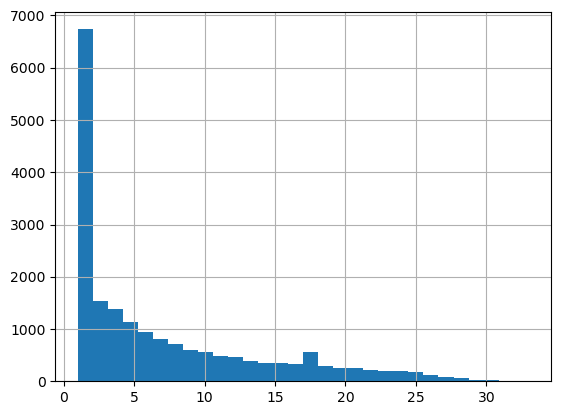

In [39]:
# Get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins=30)

In [40]:
max_seq_len = 35

In [41]:
train_text_list = train_text.tolist()

In [42]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False,
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False,
)

In [43]:
# for train set
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
sentiments = {"neutral": 0, "positive": 1, "negative": 2}
train_y = torch.tensor([sentiments[i] for i in train_label.tolist()])

# for validation set
val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor([sentiments[i] for i in val_label.tolist()])

In [44]:
# Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [45]:
# Freeze BERT Parameters
for param in bert.parameters():
    param.requires_grad = False

In [46]:
# Define Model Architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu = nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 3)
        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):
        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)

        return x

In [47]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [48]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [49]:
# Find Class Weights
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight(
    "balanced", classes=np.unique(train_label), y=train_label
)

print(class_wts)

[1.17716174 0.82395271 1.06742134]


In [50]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 30

In [51]:
# Fine Tune BERT
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds = []
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    # returns the loss and predictions
    return avg_loss, total_preds

In [52]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step, batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [53]:
# Start Model Training
# set initial loss to infinite
best_valid_loss = float("inf")

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):

    print("\n Epoch {:} / {:}".format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "saved_weights.pt")

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\nTraining Loss: {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")


 Epoch 1 / 30
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training Loss: 0.789
Validation Loss: 0.637

 Epoch 2 / 30
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training L

In [55]:
# Get predictions on test data
test_df = pd.read_csv("../data/test.csv", encoding="unicode_escape")
test_df = test_df.dropna()
test_text, test_label = test_df["text"], test_df["sentiment"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False,
)

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor([sentiments[i] for i in test_label.tolist()])

# load weights of best model
path = "saved_weights.pt"
model.load_state_dict(torch.load(path))

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))
pd.crosstab(test_y, preds)

              precision    recall  f1-score   support

           0       0.45      0.90      0.60      1430
           1       0.74      0.25      0.38      1103
           2       0.75      0.24      0.36      1001

    accuracy                           0.51      3534
   macro avg       0.65      0.46      0.45      3534
weighted avg       0.63      0.51      0.46      3534



col_0,0,1,2
row_0,,,
0,1280,82,68
1,810,280,13
2,745,16,240
